In [ ]:
import pandas as pd
import numpy as np
from statsmodels.multivariate.manova import MANOVA

# ---------------------------------------------------------
# 1. Load your data into a DataFrame
# ---------------------------------------------------------
df = pd.read_csv("sentiment_data_combined.csv")

# ---------------------------------------------------------
# 2. Centered Log-Ratio (CLR) transform for compositional data
# Manova requires normally distributed response variables when
# ---------------------------------------------------------
def clr_transform(df, cols):
    """Apply centered log-ratio transform to selected columns."""
    X = df[cols].values
    gm = np.exp(np.mean(np.log(X + 1e-12), axis=1))  # geometric mean
    clr = np.log((X + 1e-12) / gm[:, None])
    clr_df = pd.DataFrame(clr, columns=[c + "_clr" for c in cols])
    return clr_df

sent_cols = ["Positive", "Neutral", "Negative"]
clr_df = clr_transform(df, sent_cols)

df_clr = pd.concat([df[["News Organization", "Topic"]], clr_df], axis=1)

# ---------------------------------------------------------
# 3. Reshape into paired format (one row per news org)
# ---------------------------------------------------------
wide = df_clr.pivot(index="News Organization", columns="Topic")

# Flatten MultiIndex columns
wide.columns = ['_'.join(col).strip() for col in wide.columns.values]

# ---------------------------------------------------------
# 4. MANOVA: Israel vs. Venezuela on CLR-transformed sentiment
# ---------------------------------------------------------
# Dependent variables: CLR sentiment for each topic
Y_cols = [
    "Positive_clr_Israel", "Neutral_clr_Israel", "Negative_clr_Israel",
    "Positive_clr_Venezuela", "Neutral_clr_Venezuela", "Negative_clr_Venezuela"
]

# Create difference scores (paired comparison)
wide["d_Positive"] = wide["Positive_clr_Israel"] - wide["Positive_clr_Venezuela"]
wide["d_Neutral"]  = wide["Neutral_clr_Israel"]  - wide["Neutral_clr_Venezuela"]
wide["d_Negative"] = wide["Negative_clr_Israel"] - wide["Negative_clr_Venezuela"]

# MANOVA on the difference vectors (testing if mean vector = 0)
manova = MANOVA.from_formula(
    "d_Positive + d_Neutral + d_Negative ~ 1",
    data=wide
)

print(manova.mv_test())

                 Multivariate linear model
                                                            
------------------------------------------------------------
       Intercept        Value  Num DF  Den DF F Value Pr > F
------------------------------------------------------------
          Wilks' lambda 0.3519 2.0000 14.0000 12.8943 0.0007
         Pillai's trace 0.6481 2.0000 14.0000 12.8943 0.0007
 Hotelling-Lawley trace 1.8420 2.0000 14.0000 12.8943 0.0007
    Roy's greatest root 1.8420 2.0000 14.0000 12.8943 0.0007




 Paired Wilcoxon Tests:
Δ_Positive: Wilcoxon p = 0.0024, median diff = 0.229 ↑
Δ_Neutral: Wilcoxon p = 0.0739, median diff = -0.252 ↓
Δ_Negative: Wilcoxon p = 0.1046, median diff = -0.142 ↓
Δ_Polarization: Wilcoxon p = 0.0739, median diff = 0.252 ↑


/tmp/ipython-input-3809849568.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Sentiment", y="Difference", data=df_melt, palette="Set2")


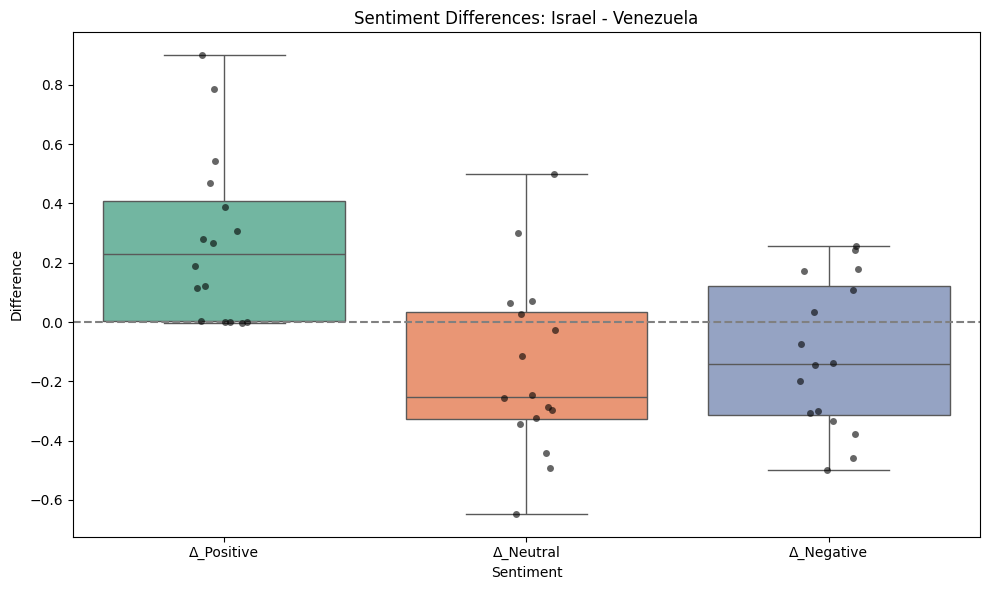

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import wilcoxon

# -------------------------------
# 1. Reshape to wide format
# -------------------------------
wide = df.pivot(index="News Organization", columns="Topic", values=["Positive", "Neutral", "Negative"])
wide.columns = ['_'.join(col).strip() for col in wide.columns.values]
wide = wide.dropna()  # Drop any incomplete pairs

# -------------------------------
# 2. Compute differences
# -------------------------------
wide["Δ_Positive"] = wide["Positive_Israel"] - wide["Positive_Venezuela"]
wide["Δ_Neutral"] = wide["Neutral_Israel"] - wide["Neutral_Venezuela"]
wide["Δ_Negative"] = wide["Negative_Israel"] - wide["Negative_Venezuela"]
wide["Polarization_Israel"] = wide["Positive_Israel"] + wide["Negative_Israel"]
wide["Polarization_Venezuela"] = wide["Positive_Venezuela"] + wide["Negative_Venezuela"]
wide["Δ_Polarization"] = wide["Polarization_Israel"] - wide["Polarization_Venezuela"]

# -------------------------------
# 3. Paired Wilcoxon tests to determine which sentiment differences are significant
# -------------------------------
def run_wilcoxon(col):
    stat, p = wilcoxon(wide[col])
    direction = "↑" if wide[col].median() > 0 else "↓"
    print(f"{col}: Wilcoxon p = {p:.4f}, median diff = {wide[col].median():.3f} {direction}")

print("\n Paired Wilcoxon Tests:")
for col in ["Δ_Positive", "Δ_Neutral", "Δ_Negative", "Δ_Polarization"]:
    run_wilcoxon(col)


# -------------------------------
# 4. Visualization
# -------------------------------
# Difference bar plots
plt.figure(figsize=(10, 6))
df_melt = wide[["Δ_Positive", "Δ_Neutral", "Δ_Negative"]].melt(var_name="Sentiment", value_name="Difference")
sns.boxplot(x="Sentiment", y="Difference", data=df_melt, palette="Set2")
sns.stripplot(x="Sentiment", y="Difference", data=df_melt, color="black", alpha=0.6)
plt.axhline(0, color="gray", linestyle="--")
plt.title("Sentiment Differences: Israel - Venezuela")
plt.tight_layout()
plt.show()

